In [ ]:
#| default_exp spectogram
#| default_cls_lvl 3

In [ ]:
#| export
from tsfast.data import *

from fastai.basics import *
# from fastai.vision.augment import RandTransform
# import h5py

### 5.3 Spectrogram-Datablock

In [ ]:
#| export
class TensorSpectrogram(TensorBase):
    def show(self, ctx=None, ax=None, title="", **kwargs):
        ax = ifnone(ax, ctx)
        if ax is None:
            _, ax = plt.subplots()
        ax.axis(False)
        n_channels = self.shape[0]
        for i, channel in enumerate(self):
            ia = ax.inset_axes((i / n_channels, 0.2, 1 / n_channels, 0.7))
#             ia = ax.inset_axes((i / n_channels, 0, 1 / n_channels, 1))
    
            ia.imshow(channel.cpu().numpy(),aspect ='auto',origin ='lower')
            if i>0: ia.set_yticks([])
            ia.set_title(f"Channel {i}")
        ax.set_title(title)
        return ax

class TensorSpectrogramInput(TensorSpectrogram): pass
class TensorSpectrogramOutput(TensorSpectrogram): pass

In [ ]:
from nbdev.config import get_config

In [ ]:
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/WienerHammerstein'
hdf_files = get_files(f_path,extensions='.hdf5',recurse=True)

In [ ]:
seq_spec = TensorSpectrogramInput(HDF2Sequence(['u'],to_cls=TensorSpectrogramInput)._hdf_extract_sequence(hdf_files[0],r_slc=2000))
seq_spec.shape

torch.Size([2000, 1])

In [ ]:
#| exporti
def complex_norm(
        complex_tensor: Tensor,
        power: float = 1.0
) -> Tensor:
    if power == 1.0:
        return torch.norm(complex_tensor, 2, -1)
    return torch.norm(complex_tensor, 2, -1).pow(power)

In [ ]:
#| exporti
def spectrogram(
        waveform: Tensor,
        pad: int,
        window: Tensor,
        n_fft: int,
        hop_length: int,
        win_length: int,
        power: Optional[float],
        normalized: bool
) -> Tensor:
    if pad > 0:
        waveform = torch.nn.functional.pad(waveform, (pad, pad), "constant")

    # pack batch
    shape = waveform.size()
    waveform = waveform.view(-1, shape[-1])

    # default values are consistent with librosa.core.spectrum._spectrogram
    spec_f = torch.view_as_real(torch.stft(
        waveform, n_fft, hop_length, win_length, window, True, "reflect", False, True,return_complex=True
    ))

    # unpack batch
    spec_f = spec_f.view(shape[:-1] + spec_f.shape[-3:])

    if normalized:
        spec_f /= window.pow(2.).sum().sqrt()
    if power is not None:
        spec_f = complex_norm(spec_f, power=power)

    return spec_f

In [ ]:
#| exporti
from typing import Callable

class Spectrogram(torch.nn.Module):
    r"""Create a spectrogram from a audio signal.

    Args:
        n_fft (int, optional): Size of FFT, creates ``n_fft // 2 + 1`` bins. (Default: ``400``)
        win_length (int or None, optional): Window size. (Default: ``n_fft``)
        hop_length (int or None, optional): Length of hop between STFT windows. (Default: ``win_length // 2``)
        pad (int, optional): Two sided padding of signal. (Default: ``0``)
        window_fn (Callable[..., Tensor], optional): A function to create a window tensor
            that is applied/multiplied to each frame/window. (Default: ``torch.hann_window``)
        power (float or None, optional): Exponent for the magnitude spectrogram,
            (must be > 0) e.g., 1 for energy, 2 for power, etc.
            If None, then the complex spectrum is returned instead. (Default: ``2``)
        normalized (bool, optional): Whether to normalize by magnitude after stft. (Default: ``False``)
        wkwargs (dict or None, optional): Arguments for window function. (Default: ``None``)
    """
    __constants__ = ['n_fft', 'win_length', 'hop_length', 'pad', 'power', 'normalized']

    def __init__(self,
                 n_fft: int = 400,
                 win_length: Optional[int] = None,
                 hop_length: Optional[int] = None,
                 pad: int = 0,
                 window_fn: Callable[..., Tensor] = torch.hann_window,
                 power: Optional[float] = 2.,
                 normalized: bool = False,
                 wkwargs: Optional[dict] = None) -> None:
        super(Spectrogram, self).__init__()
        self.n_fft = n_fft
        # number of FFT bins. the returned STFT result will have n_fft // 2 + 1
        # number of frequecies due to onesided=True in torch.stft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 2
        window = window_fn(self.win_length) if wkwargs is None else window_fn(self.win_length, **wkwargs)
        self.register_buffer('window', window)
        self.pad = pad
        self.power = power
        self.normalized = normalized

    def forward(self, waveform: Tensor) -> Tensor:
        r"""
        Args:
            waveform (Tensor): Tensor of audio of dimension (..., time).

        Returns:
            Tensor: Dimension (..., freq, time), where freq is
            ``n_fft // 2 + 1`` where ``n_fft`` is the number of
            Fourier bins, and time is the number of window hops (n_frame).
        """
        return spectrogram(waveform, self.pad, self.window, self.n_fft, self.hop_length,
                             self.win_length, self.power, self.normalized)

In [ ]:
#| export
@delegates(Spectrogram, keep=True)
class Sequence2Spectrogram(Transform):
    '''calculates the FFT of a sequence'''
    
    def __init__(self,scaling='log',**kwargs): 
        self.scaling=scaling
        self.tfm = Spectrogram(**kwargs)
        
    def encodes(self, o:TensorSpectrogram): 
        if o.device != self.tfm.window.device: self.tfm.window = self.tfm.window.to(o.device)
#         import pdb;pdb.set_trace()
        spec = self.tfm(o.transpose(-1,-2).contiguous())
        if self.scaling == 'log': spec = torch.log10(spec + 1e-10)
        return spec

In [ ]:
#| export
class SpectrogramBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False,n_fft=100,hop_length=None,normalized=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Sequence2Spectrogram(n_fft=n_fft,hop_length=hop_length,normalized=normalized)],
                                dls_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Sequence, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorSpectrogramInput,padding=False,n_fft=100,hop_length=None,normalized=False, **kwargs):
        return cls(HDF2Sequence(clm_names,to_cls=seq_cls,**kwargs), padding,n_fft=n_fft,hop_length=hop_length,normalized=normalized)

In [ ]:
dls_spec = DataBlock(blocks=(SpectrogramBlock.from_hdf(['u','y'],n_fft=100,hop_length=10,normalized=True),
                             SequenceBlock.from_hdf(['y'],TensorSequencesOutput)),
                get_items= CreateDict([DfHDFCreateWindows(win_sz=2000+1,stp_sz=10,clm='u')]),
                splitter=ApplyToDict(ParentSplitter())).dataloaders(hdf_files)

In [ ]:
dls_spec.one_batch()[0].shape

torch.Size([64, 1, 51, 201])

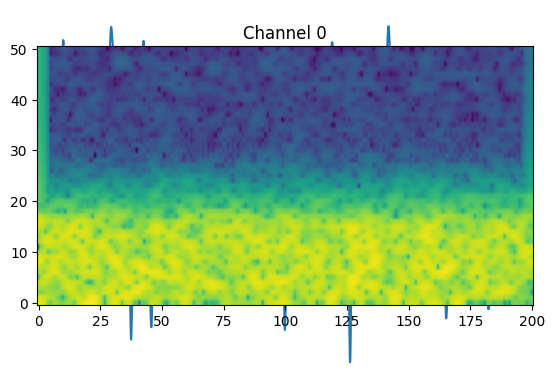

In [ ]:
dls_spec.show_batch(max_n=1)

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()